In [50]:

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import logging
import os
import copy
from src.utils import set_logger
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import src.data.datasets as data
import src.data.preprocessor as pre

dataset = data.get_dataset("CMAPSS1")
split_dataset = pre.split_dataset(dataset)
proc_dataset = pre.preprocess_split_dataset(split_dataset)
torch_dataset = pre.to_torch_dataset(proc_dataset)

# logger configuration
log_dir = f"experiments/{dataset['name']}"

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
set_logger(os.path.join(log_dir, 'train.log'))

In [52]:
import src.train as train

# system configuration
torch.manual_seed(1)

best_result = np.PINF
best_i = None
best_params = None
n_epochs = 10

for i, split in enumerate(torch_dataset["train_splits"][:1]):
    logging.info(f"Split {i+1}/{len(torch_dataset['train_splits'])}.")
    params, result = train.tune_hyperparams(split, n_epochs)
    if result < best_result:
        best_result = result
        best_i = i
        best_params = params
    logging.info(f"Split {i+1} best RMSE={result} for params:", params)

logging.info(f"Done. Best RMSE={best_result} on split {best_i+1} for params:", best_params)
logging.info(f"Training model on entire training dataset.")
m = train.create_model(input_dim=torch_dataset["in_dim"], **best_params)
model = m["model"]
mean_optim = m["mean_optim"]
gp_optim = m["gp_optim"]
loss_fn = m["loss_fn"]
n_adapt = m["n_adapt"]
inner_lr = m["inner_lr"]
train.train_and_evaluate(model, torch_dataset, mean_optim, gp_optim, loss_fn, n_epochs, n_adapt, inner_lr)

logging.info(f"Saving trained model to {log_dir}.")
model_name = f"dmegp_CMAPSS.pth"
state = {
    **best_params,
    "input_dim": torch_dataset["in_dim"],
    "state_dict": copy.deepcopy(model.state_dict())
}
torch.save(state, os.path.join(log_dir, model_name))

logging.info(f"Evaluating trained model on ALL test datapoints.")
train.evaluate(model, torch_dataset["test"], loss_fn, n_adapt, inner_lr, "test", only_last=False)
logging.info("Done.")

Split 1/10.


[I 2022-06-12 13:16:54,392] A new study created in memory with name: no-name-d2b83d22-71eb-4034-81b6-adb703228ccf


Epoch 1/10
TRAIN_loss : 31958.219
VAL_score : 7.895
VAL_loss : 9015.438
Found new best error at 0
Epoch 2/10
TRAIN_loss : 4590.722
VAL_score : 2.976
VAL_loss : 1666.024
Found new best error at 1
Epoch 3/10
TRAIN_loss : 2508.733
VAL_score : 1.904
VAL_loss : 1579.752
Found new best error at 2
Epoch 4/10
TRAIN_loss : 2433.079
VAL_score : 1.520
VAL_loss : 1484.152
Found new best error at 3
Epoch 5/10
TRAIN_loss : 2321.194
VAL_score : 1.508
VAL_loss : 1505.202
Found new best error at 4
Epoch 6/10
TRAIN_loss : 2316.040
VAL_score : 1.612
VAL_loss : 1548.971
Epoch 7/10
TRAIN_loss : 2326.245
VAL_score : 1.137
VAL_loss : 1458.272
Found new best error at 6
Epoch 8/10
TRAIN_loss : 2174.224
VAL_score : 1.888
VAL_loss : 1381.495
Epoch 9/10
TRAIN_loss : 2294.934
VAL_score : 1.753
VAL_loss : 1451.784
Epoch 10/10
TRAIN_loss : 2232.696
VAL_score : 1.237
VAL_loss : 1349.027


[I 2022-06-12 13:17:17,264] Trial 0 finished with value: 1.1373979711201085 and parameters: {'hidden_dim': 64, 'activation': 'elu', 'lr': 0.004210276948114171, 'inner_lr': 0.0013085175117216988, 'l2_penalty': 0.00015135145397823706}. Best is trial 0 with value: 1.1373979711201085.


Epoch 1/10
TRAIN_loss : 29419.352
VAL_score : 10.215
VAL_loss : 15370.455
Found new best error at 0
Epoch 2/10
TRAIN_loss : 14010.753
VAL_score : 4.186
VAL_loss : 10865.889
Found new best error at 1


[I 2022-06-12 13:17:21,408] Trial 1 pruned. 


Epoch 1/10
TRAIN_loss : 70147.221
VAL_score : 4.255
VAL_loss : 50180.316
Found new best error at 0
Epoch 2/10
TRAIN_loss : 44050.524
VAL_score : 10.874
VAL_loss : 31053.235
Epoch 3/10
TRAIN_loss : 27230.733
VAL_score : 14.941
VAL_loss : 18252.854
Epoch 4/10
TRAIN_loss : 15346.914
VAL_score : 12.851
VAL_loss : 10109.630
Epoch 5/10
TRAIN_loss : 8476.410
VAL_score : 6.293
VAL_loss : 5872.030
Epoch 6/10
TRAIN_loss : 5067.272
VAL_score : 3.278
VAL_loss : 3528.385
Found new best error at 5
Epoch 7/10
TRAIN_loss : 3453.794
VAL_score : 2.812
VAL_loss : 2575.721
Found new best error at 6
Epoch 8/10
TRAIN_loss : 2962.087
VAL_score : 3.028
VAL_loss : 2260.632
Epoch 9/10
TRAIN_loss : 2795.724
VAL_score : 3.641
VAL_loss : 2175.598
Epoch 10/10
TRAIN_loss : 2689.156
VAL_score : 2.717
VAL_loss : 2062.454
Found new best error at 9


[I 2022-06-12 13:17:45,213] Trial 2 finished with value: 2.7170550052859284 and parameters: {'hidden_dim': 160, 'activation': 'elu', 'lr': 0.000673699916273704, 'inner_lr': 0.0006751899295857182, 'l2_penalty': 0.00014826857103522132}. Best is trial 0 with value: 1.1373979711201085.


Epoch 1/10
TRAIN_loss : 23123.820
VAL_score : 5.297
VAL_loss : 4817.428
Found new best error at 0
Epoch 2/10
TRAIN_loss : 2923.752
VAL_score : 4.178
VAL_loss : 1324.580
Found new best error at 1
Epoch 3/10
TRAIN_loss : 1863.337
VAL_score : 2.504
VAL_loss : 1222.002
Found new best error at 2
Epoch 4/10
TRAIN_loss : 1633.760
VAL_score : 2.187
VAL_loss : 1099.346
Found new best error at 3
Epoch 5/10
TRAIN_loss : 1528.893
VAL_score : 2.150
VAL_loss : 1046.833
Found new best error at 4
Epoch 6/10
TRAIN_loss : 1488.725
VAL_score : 1.875
VAL_loss : 1013.992
Found new best error at 5
Epoch 7/10
TRAIN_loss : 1410.244
VAL_score : 1.391
VAL_loss : 1034.915
Found new best error at 6
Epoch 8/10
TRAIN_loss : 1426.476
VAL_score : 1.988
VAL_loss : 975.332
Epoch 9/10
TRAIN_loss : 1364.885
VAL_score : 1.730
VAL_loss : 938.399
Epoch 10/10
TRAIN_loss : 1348.262
VAL_score : 1.324
VAL_loss : 964.066
Found new best error at 9


[I 2022-06-12 13:18:07,306] Trial 3 finished with value: 1.323856007595373 and parameters: {'hidden_dim': 256, 'activation': 'relu', 'lr': 0.0037616714418975622, 'inner_lr': 0.0024276621268843578, 'l2_penalty': 0.001818502994286088}. Best is trial 0 with value: 1.1373979711201085.


Epoch 1/10
TRAIN_loss : 32449.806
VAL_score : 6.811
VAL_loss : 27894.312
Found new best error at 0
Epoch 2/10
TRAIN_loss : 25604.485
VAL_score : 7.288
VAL_loss : 23278.161
Epoch 3/10
TRAIN_loss : 21576.438
VAL_score : 8.026
VAL_loss : 19923.135
Epoch 4/10
TRAIN_loss : 18604.368
VAL_score : 8.733
VAL_loss : 17365.980


[I 2022-06-12 13:18:16,377] Trial 4 pruned. 


Epoch 1/10
TRAIN_loss : 39535.290
VAL_score : 12.410
VAL_loss : 17350.530
Found new best error at 0
Epoch 2/10
TRAIN_loss : 15014.316
VAL_score : 6.020
VAL_loss : 6825.444
Found new best error at 1
Epoch 3/10
TRAIN_loss : 4801.915
VAL_score : 2.941
VAL_loss : 1860.041
Found new best error at 2
Epoch 4/10
TRAIN_loss : 2364.122
VAL_score : 3.866
VAL_loss : 1517.389


[I 2022-06-12 13:18:25,326] Trial 5 pruned. 


Epoch 1/10
TRAIN_loss : 17647.875
VAL_score : 2.941
VAL_loss : 1509.176
Found new best error at 0
Epoch 2/10
TRAIN_loss : 1915.402
VAL_score : 2.339
VAL_loss : 1251.426
Found new best error at 1
Epoch 3/10
TRAIN_loss : 1725.310
VAL_score : 2.686
VAL_loss : 1097.432
Epoch 4/10
TRAIN_loss : 1553.248
VAL_score : 1.911
VAL_loss : 1137.926
Found new best error at 3


[I 2022-06-12 13:18:33,881] Trial 6 pruned. 


Epoch 1/10
TRAIN_loss : 31737.240
VAL_score : 7.860
VAL_loss : 12477.509
Found new best error at 0
Epoch 2/10
TRAIN_loss : 10224.244
VAL_score : 4.485
VAL_loss : 2231.157
Found new best error at 1


[I 2022-06-12 13:18:38,173] Trial 7 pruned. 


Epoch 1/10
TRAIN_loss : 68623.184
VAL_score : 2.864
VAL_loss : 47400.349
Found new best error at 0
Epoch 2/10
TRAIN_loss : 39243.706
VAL_score : 4.280
VAL_loss : 28559.618
Epoch 3/10
TRAIN_loss : 25033.076
VAL_score : 5.516
VAL_loss : 18899.776
Epoch 4/10
TRAIN_loss : 16237.876
VAL_score : 5.816
VAL_loss : 12482.962
Epoch 5/10
TRAIN_loss : 10520.937
VAL_score : 4.899
VAL_loss : 8359.266
Epoch 6/10
TRAIN_loss : 6826.666
VAL_score : 3.323
VAL_loss : 5390.655
Epoch 7/10
TRAIN_loss : 4306.533
VAL_score : 2.733
VAL_loss : 3611.056
Found new best error at 6
Epoch 8/10
TRAIN_loss : 3118.872
VAL_score : 2.318
VAL_loss : 2786.075
Found new best error at 7
Epoch 9/10
TRAIN_loss : 2759.160
VAL_score : 2.405
VAL_loss : 2588.942
Epoch 10/10
TRAIN_loss : 2629.447
VAL_score : 2.229
VAL_loss : 2533.118
Found new best error at 9


[I 2022-06-12 13:19:00,315] Trial 8 finished with value: 2.22869752071279 and parameters: {'hidden_dim': 64, 'activation': 'elu', 'lr': 0.000842313283382412, 'inner_lr': 0.0002449500213952014, 'l2_penalty': 0.0013475463686629056}. Best is trial 0 with value: 1.1373979711201085.


Epoch 1/10
TRAIN_loss : 35063.340
VAL_score : 4.337
VAL_loss : 9314.759
Found new best error at 0
Epoch 2/10
TRAIN_loss : 9167.988
VAL_score : 6.145
VAL_loss : 6122.592
Epoch 3/10
TRAIN_loss : 5790.788
VAL_score : 3.491
VAL_loss : 4465.173
Found new best error at 2
Epoch 4/10
TRAIN_loss : 4299.920
VAL_score : 8.231
VAL_loss : 3630.720
Epoch 5/10
TRAIN_loss : 3345.331
VAL_score : 6.111
VAL_loss : 2904.411
Epoch 6/10
TRAIN_loss : 2626.631
VAL_score : 4.254
VAL_loss : 2213.455
Epoch 7/10
TRAIN_loss : 2130.992
VAL_score : 3.854
VAL_loss : 1672.356
Epoch 8/10
TRAIN_loss : 1829.628
VAL_score : 2.598
VAL_loss : 1362.145
Found new best error at 7
Epoch 9/10
TRAIN_loss : 1703.444
VAL_score : 2.162
VAL_loss : 1237.483
Found new best error at 8
Epoch 10/10
TRAIN_loss : 1570.925
VAL_score : 3.846
VAL_loss : 1158.635


[I 2022-06-12 13:19:21,149] Trial 9 pruned. 


Epoch 1/10
TRAIN_loss : 25559.015
VAL_score : 4.305
VAL_loss : 7830.658
Found new best error at 0
Epoch 2/10
TRAIN_loss : 6160.849
VAL_score : 1.991
VAL_loss : 3572.412
Found new best error at 1
Epoch 3/10
TRAIN_loss : 3524.568
VAL_score : 1.238
VAL_loss : 2290.493
Found new best error at 2
Epoch 4/10
TRAIN_loss : 2660.815
VAL_score : 1.453
VAL_loss : 2103.290
Epoch 5/10
TRAIN_loss : 2472.582
VAL_score : 1.815
VAL_loss : 1728.723
Epoch 6/10
TRAIN_loss : 2217.639
VAL_score : 1.658
VAL_loss : 1472.869
Epoch 7/10
TRAIN_loss : 1821.881
VAL_score : 2.491
VAL_loss : 1406.770
Epoch 8/10
TRAIN_loss : 1623.811
VAL_score : 1.417
VAL_loss : 1308.426
Epoch 9/10
TRAIN_loss : 1536.559
VAL_score : 1.164
VAL_loss : 1218.859
Found new best error at 8
Epoch 10/10
TRAIN_loss : 1645.733
VAL_score : 2.318
VAL_loss : 1272.265


[I 2022-06-12 13:19:41,901] Trial 10 pruned. 


Epoch 1/10
TRAIN_loss : 19879.159
VAL_score : 3.244
VAL_loss : 6634.141
Found new best error at 0
Epoch 2/10
TRAIN_loss : 5669.543
VAL_score : 1.366
VAL_loss : 2965.744
Found new best error at 1
Epoch 3/10
TRAIN_loss : 3156.563
VAL_score : 2.252
VAL_loss : 1650.596
Epoch 4/10
TRAIN_loss : 2174.606
VAL_score : 1.571
VAL_loss : 1330.898


[I 2022-06-12 13:19:50,137] Trial 11 pruned. 


Epoch 1/10
TRAIN_loss : 85288.387
VAL_score : 2.186
VAL_loss : 64086.774
Found new best error at 0
Epoch 2/10
TRAIN_loss : 76436.851
VAL_score : 2.148
VAL_loss : 57606.546
Found new best error at 1
Epoch 3/10
TRAIN_loss : 68886.102
VAL_score : 2.363
VAL_loss : 51767.406
Epoch 4/10
TRAIN_loss : 62299.686
VAL_score : 2.877
VAL_loss : 46723.473
Epoch 5/10
TRAIN_loss : 56433.741
VAL_score : 3.665
VAL_loss : 42184.885
Epoch 6/10
TRAIN_loss : 51171.836
VAL_score : 4.761
VAL_loss : 38115.214
Epoch 7/10
TRAIN_loss : 46369.978
VAL_score : 5.924
VAL_loss : 34450.868
Epoch 8/10
TRAIN_loss : 41988.746
VAL_score : 7.129
VAL_loss : 31130.161
Epoch 9/10
TRAIN_loss : 38024.562
VAL_score : 8.458
VAL_loss : 27930.019
Epoch 10/10
TRAIN_loss : 34373.367
VAL_score : 9.704
VAL_loss : 25104.571


[I 2022-06-12 13:20:14,870] Trial 12 pruned. 


Epoch 1/10
TRAIN_loss : 56963.304
VAL_score : 2.891
VAL_loss : 44649.036
Found new best error at 0
Epoch 2/10
TRAIN_loss : 44283.586
VAL_score : 5.947
VAL_loss : 35755.670


[I 2022-06-12 13:20:19,090] Trial 13 pruned. 


Epoch 1/10
TRAIN_loss : 36496.916
VAL_score : 2.713
VAL_loss : 18975.343
Found new best error at 0
Epoch 2/10
TRAIN_loss : 17779.598
VAL_score : 3.119
VAL_loss : 14607.320


[I 2022-06-12 13:20:23,246] Trial 14 pruned. 


Epoch 1/10
TRAIN_loss : 80874.387
VAL_score : 3.360
VAL_loss : 36148.399
Found new best error at 0
Epoch 2/10
TRAIN_loss : 61984.741
VAL_score : 7.221
VAL_loss : 27309.314
Epoch 3/10
TRAIN_loss : 47338.865
VAL_score : 12.197
VAL_loss : 20601.695
Epoch 4/10
TRAIN_loss : 35878.511
VAL_score : 16.180
VAL_loss : 15178.071


[I 2022-06-12 13:20:33,549] Trial 15 pruned. 


Epoch 1/10
TRAIN_loss : 78680.517
VAL_score : 3.282
VAL_loss : 51821.066
Found new best error at 0
Epoch 2/10
TRAIN_loss : 57721.746
VAL_score : 5.231
VAL_loss : 38550.424
Epoch 3/10
TRAIN_loss : 43360.845
VAL_score : 8.764
VAL_loss : 28672.235
Epoch 4/10
TRAIN_loss : 32607.646
VAL_score : 11.833
VAL_loss : 21229.228


[I 2022-06-12 13:20:43,858] Trial 16 pruned. 


Epoch 1/10
TRAIN_loss : 55265.789
VAL_score : 3.184
VAL_loss : 25447.648
Found new best error at 0
Epoch 2/10
TRAIN_loss : 26557.192
VAL_score : 3.269
VAL_loss : 18096.760


[I 2022-06-12 13:20:55,875] Trial 17 pruned. 


Epoch 1/10
TRAIN_loss : 67747.691
VAL_score : 4.011
VAL_loss : 40868.329
Found new best error at 0
Epoch 2/10
TRAIN_loss : 34015.624
VAL_score : 8.425
VAL_loss : 21498.729
Epoch 3/10
TRAIN_loss : 18173.422
VAL_score : 8.216
VAL_loss : 11838.273
Epoch 4/10
TRAIN_loss : 10478.919
VAL_score : 5.197
VAL_loss : 7140.515


[I 2022-06-12 13:21:22,214] Trial 18 pruned. 


Epoch 1/10
TRAIN_loss : 23457.484
VAL_score : 7.416
VAL_loss : 14325.637
Found new best error at 0
Epoch 2/10
TRAIN_loss : 12978.127
VAL_score : 9.014
VAL_loss : 10352.870


[I 2022-06-12 13:21:34,349] Trial 19 pruned. 


Epoch 1/10
TRAIN_loss : 92819.219
VAL_score : 2.067
VAL_loss : 86777.329
Found new best error at 0
Epoch 2/10
TRAIN_loss : 82893.402
VAL_score : 1.682
VAL_loss : 77870.877
Found new best error at 1
Epoch 3/10
TRAIN_loss : 74102.560
VAL_score : 1.521
VAL_loss : 69892.780
Found new best error at 2
Epoch 4/10
TRAIN_loss : 66221.328
VAL_score : 1.917
VAL_loss : 62636.485


[I 2022-06-12 13:22:02,571] Trial 20 pruned. 


Epoch 1/10
TRAIN_loss : 44141.282
VAL_score : 10.226
VAL_loss : 12379.627
Found new best error at 0
Epoch 2/10
TRAIN_loss : 5371.922
VAL_score : 1.876
VAL_loss : 2687.724
Found new best error at 1
Epoch 3/10
TRAIN_loss : 2567.600
VAL_score : 4.262
VAL_loss : 2500.358
Epoch 4/10
TRAIN_loss : 2484.384
VAL_score : 1.973
VAL_loss : 2161.185
Epoch 5/10
TRAIN_loss : 2317.183
VAL_score : 2.054
VAL_loss : 2075.939
Epoch 6/10
TRAIN_loss : 2311.026
VAL_score : 2.550
VAL_loss : 2015.828
Epoch 7/10
TRAIN_loss : 2209.501
VAL_score : 2.073
VAL_loss : 2155.555
Epoch 8/10
TRAIN_loss : 2160.542
VAL_score : 2.059
VAL_loss : 1951.363
Epoch 9/10
TRAIN_loss : 2154.901
VAL_score : 2.132
VAL_loss : 1839.634
Epoch 10/10
TRAIN_loss : 2236.287
VAL_score : 2.659
VAL_loss : 2028.928


[I 2022-06-12 13:23:06,207] Trial 21 pruned. 


Epoch 1/10
TRAIN_loss : 24843.556
VAL_score : 2.786
VAL_loss : 13824.501
Found new best error at 0
Epoch 2/10
TRAIN_loss : 12720.123
VAL_score : 1.680
VAL_loss : 9483.406
Found new best error at 1
Epoch 3/10
TRAIN_loss : 8812.356
VAL_score : 1.872
VAL_loss : 6654.171
Epoch 4/10
TRAIN_loss : 6362.022
VAL_score : 2.067
VAL_loss : 4930.240
Epoch 5/10
TRAIN_loss : 4710.006
VAL_score : 2.506
VAL_loss : 3745.366
Epoch 6/10
TRAIN_loss : 3654.175
VAL_score : 1.394
VAL_loss : 2950.756
Found new best error at 5
Epoch 7/10
TRAIN_loss : 3059.125
VAL_score : 2.150
VAL_loss : 2606.831
Epoch 8/10
TRAIN_loss : 2657.843
VAL_score : 1.230
VAL_loss : 2572.978
Found new best error at 7
Epoch 9/10
TRAIN_loss : 2417.986
VAL_score : 3.655
VAL_loss : 2337.817
Epoch 10/10
TRAIN_loss : 2243.882
VAL_score : 1.779
VAL_loss : 1940.841


[I 2022-06-12 13:24:01,184] Trial 22 pruned. 


Epoch 1/10
TRAIN_loss : 13343.221
VAL_score : 2.999
VAL_loss : 2031.200
Found new best error at 0
Epoch 2/10
TRAIN_loss : 2492.204
VAL_score : 2.086
VAL_loss : 1788.705
Found new best error at 1
Epoch 3/10
TRAIN_loss : 2372.636
VAL_score : 3.547
VAL_loss : 1759.224
Epoch 4/10
TRAIN_loss : 2597.670
VAL_score : 3.407
VAL_loss : 1852.803


[I 2022-06-12 13:24:26,683] Trial 23 pruned. 


Epoch 1/10
TRAIN_loss : 62673.168
VAL_score : 6.927
VAL_loss : 33221.317
Found new best error at 0
Epoch 2/10
TRAIN_loss : 25977.724
VAL_score : 10.515
VAL_loss : 12925.371


[I 2022-06-12 13:24:40,132] Trial 24 pruned. 


Epoch 1/10
TRAIN_loss : 52584.478
VAL_score : 4.765
VAL_loss : 22115.533
Found new best error at 0
Epoch 2/10
TRAIN_loss : 11427.025
VAL_score : 3.076
VAL_loss : 4411.909
Found new best error at 1
Epoch 3/10
TRAIN_loss : 3049.744
VAL_score : 3.508
VAL_loss : 2505.536
Epoch 4/10
TRAIN_loss : 2611.990
VAL_score : 2.263
VAL_loss : 2480.402
Found new best error at 3
Epoch 5/10
TRAIN_loss : 2540.241
VAL_score : 3.917
VAL_loss : 2294.174
Epoch 6/10
TRAIN_loss : 2412.742
VAL_score : 3.634
VAL_loss : 2109.400
Epoch 7/10
TRAIN_loss : 2321.083
VAL_score : 2.601
VAL_loss : 2195.454
Epoch 8/10
TRAIN_loss : 2326.843
VAL_score : 2.035
VAL_loss : 2025.882
Found new best error at 7
Epoch 9/10
TRAIN_loss : 2170.851
VAL_score : 2.611
VAL_loss : 1851.291
Epoch 10/10
TRAIN_loss : 2149.502
VAL_score : 2.340
VAL_loss : 1810.138


[I 2022-06-12 13:25:44,238] Trial 25 pruned. 


Epoch 1/10
TRAIN_loss : 34922.264
VAL_score : 5.403
VAL_loss : 29751.274
Found new best error at 0
Epoch 2/10
TRAIN_loss : 27592.566
VAL_score : 5.666
VAL_loss : 25107.371


[I 2022-06-12 13:25:56,313] Trial 26 pruned. 


Epoch 1/10
TRAIN_loss : 28107.788
VAL_score : 4.268
VAL_loss : 10873.334
Found new best error at 0
Epoch 2/10
TRAIN_loss : 10048.494
VAL_score : 3.553
VAL_loss : 6397.069
Found new best error at 1


[I 2022-06-12 13:26:07,579] Trial 27 pruned. 


Epoch 1/10
TRAIN_loss : 54090.498
VAL_score : 4.141
VAL_loss : 26762.404
Found new best error at 0
Epoch 2/10
TRAIN_loss : 22196.575
VAL_score : 7.121
VAL_loss : 12089.892


[I 2022-06-12 13:26:20,380] Trial 28 pruned. 


Epoch 1/10
TRAIN_loss : 27811.212
VAL_score : 3.996
VAL_loss : 9118.973
Found new best error at 0
Epoch 2/10
TRAIN_loss : 7489.030
VAL_score : 2.309
VAL_loss : 4553.760
Found new best error at 1
Epoch 3/10
TRAIN_loss : 3934.757
VAL_score : 1.719
VAL_loss : 3113.560
Found new best error at 2
Epoch 4/10
TRAIN_loss : 2894.044
VAL_score : 1.439
VAL_loss : 2275.777
Found new best error at 3
Epoch 5/10
TRAIN_loss : 2182.240
VAL_score : 1.059
VAL_loss : 1762.147
Found new best error at 4
Epoch 6/10
TRAIN_loss : 1810.165
VAL_score : 1.483
VAL_loss : 1528.757
Epoch 7/10
TRAIN_loss : 1771.774
VAL_score : 1.081
VAL_loss : 1427.184
Epoch 8/10
TRAIN_loss : 1723.537
VAL_score : 1.258
VAL_loss : 1396.208
Epoch 9/10
TRAIN_loss : 1589.206
VAL_score : 1.650
VAL_loss : 1502.367
Epoch 10/10
TRAIN_loss : 1740.982
VAL_score : 1.510
VAL_loss : 1309.472


[I 2022-06-12 13:27:16,803] Trial 29 pruned. 


Epoch 1/10
TRAIN_loss : 57541.291
VAL_score : 2.826
VAL_loss : 35946.868
Found new best error at 0
Epoch 2/10
TRAIN_loss : 28095.769
VAL_score : 2.747
VAL_loss : 21145.027
Found new best error at 1
Epoch 3/10
TRAIN_loss : 20198.788
VAL_score : 2.096
VAL_loss : 17279.282
Found new best error at 2
Epoch 4/10
TRAIN_loss : 17599.045
VAL_score : 1.877
VAL_loss : 15494.286
Found new best error at 3
Epoch 5/10
TRAIN_loss : 16081.978
VAL_score : 2.232
VAL_loss : 14267.713
Epoch 6/10
TRAIN_loss : 14903.743
VAL_score : 2.314
VAL_loss : 13207.746
Epoch 7/10
TRAIN_loss : 13881.022
VAL_score : 2.069
VAL_loss : 12281.024
Epoch 8/10
TRAIN_loss : 12940.234
VAL_score : 1.771
VAL_loss : 11430.613
Found new best error at 7
Epoch 9/10
TRAIN_loss : 12046.020
VAL_score : 1.778
VAL_loss : 10614.932
Epoch 10/10
TRAIN_loss : 11226.968
VAL_score : 1.859
VAL_loss : 9870.423


[I 2022-06-12 13:27:57,145] Trial 30 finished with value: 1.7714502236835417 and parameters: {'hidden_dim': 64, 'activation': 'tanh', 'lr': 0.0013865028342076975, 'inner_lr': 0.00012227893996098478, 'l2_penalty': 0.0006818677417390197}. Best is trial 0 with value: 1.1373979711201085.


Epoch 1/10
TRAIN_loss : 18903.398
VAL_score : 9.538
VAL_loss : 11808.807
Found new best error at 0
Epoch 2/10
TRAIN_loss : 9721.808
VAL_score : 11.224
VAL_loss : 8503.894
Epoch 3/10
TRAIN_loss : 7268.614
VAL_score : 11.502
VAL_loss : 6495.322
Epoch 4/10
TRAIN_loss : 5598.518
VAL_score : 11.065
VAL_loss : 5079.412


[I 2022-06-12 13:28:12,460] Trial 31 pruned. 


Split 1 best RMSE=1.1373979711201085 for params:
Done. Best RMSE=1.1373979711201085 on split 1 for params:
Training model on entire training dataset.
Epoch 1/10
TRAIN_loss : 30615.823
VAL_score : 4.505
VAL_loss : 6926.076
Found new best error at 0
Epoch 2/10
TRAIN_loss : 4410.352
VAL_score : 4.337
VAL_loss : 1259.663
Found new best error at 1
Epoch 3/10
TRAIN_loss : 2566.565
VAL_score : 4.432
VAL_loss : 1029.698
Epoch 4/10
TRAIN_loss : 2430.162
VAL_score : 4.001
VAL_loss : 1016.155
Found new best error at 3
Epoch 5/10
TRAIN_loss : 2439.056
VAL_score : 3.909
VAL_loss : 973.051
Found new best error at 4
Epoch 6/10
TRAIN_loss : 2405.103
VAL_score : 3.761
VAL_loss : 1021.066
Found new best error at 5
Epoch 7/10
TRAIN_loss : 2375.252
VAL_score : 3.912
VAL_loss : 870.773
Epoch 8/10
TRAIN_loss : 2250.951
VAL_score : 3.772
VAL_loss : 875.542
Epoch 9/10
TRAIN_loss : 2191.679
VAL_score : 3.333
VAL_loss : 854.828
Found new best error at 8
Epoch 10/10
TRAIN_loss : 2246.279
VAL_score : 3.181
VAL_lo

100%|██████████| 100/100 [23:14<00:00, 13.95s/it, current_loss_and_rmse=810.132 and 4.976]

TEST_score : 4.976
TEST_loss : 810.132
Done.


In [53]:
model

DMEGP(
  (mean_fn): Warping_mean(
    (mean_fn): MLP(
      (fc1): Linear(in_features=32, out_features=64, bias=True)
      (fc2): Linear(in_features=64, out_features=1, bias=True)
      (activation): ELU(alpha=1.0)
    )
    (iwarping_fn): MLP_embed(
      (fc1): Linear(in_features=16, out_features=32, bias=True)
      (activation): ELU(alpha=1.0)
    )
  )
  (embed_fn): MLP_embed(
    (fc1): Linear(in_features=16, out_features=32, bias=True)
    (activation): ELU(alpha=1.0)
  )
  (gp_model): GPRegression(
    (kernel): Warping(
      (kern): RBF()
      (iwarping_fn): MLP_embed(
        (fc1): Linear(in_features=16, out_features=32, bias=True)
        (activation): ELU(alpha=1.0)
      )
    )
    (mean_function): Warping_mean(
      (mean_fn): MLP(
        (fc1): Linear(in_features=32, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=1, bias=True)
        (activation): ELU(alpha=1.0)
      )
      (iwarping_fn): MLP_embed(
        (fc1): Linear(in_featu

  1%|          | 1/100 [00:03<06:11,  3.75s/it, current_loss_and_rmse_and_rmseMean=155.020 and 5.516 and 56.614]c:\Users\Alireza\.conda\envs\mixed_effect\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\Alireza\.conda\envs\mixed_effect\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=o

(4.21771334539836, 847.0079730460496)

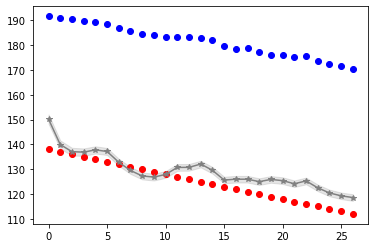

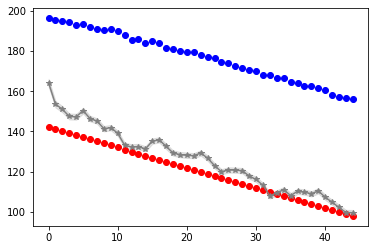

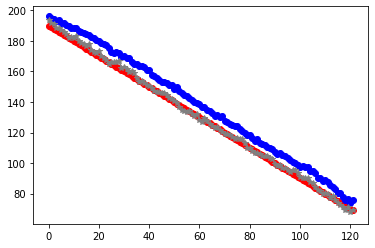

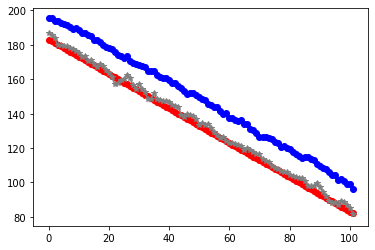

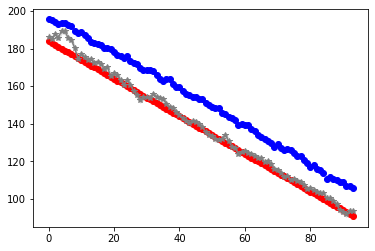

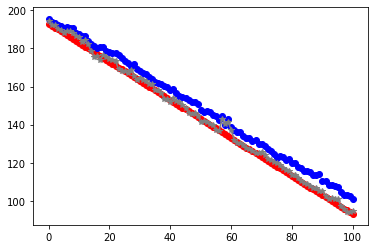

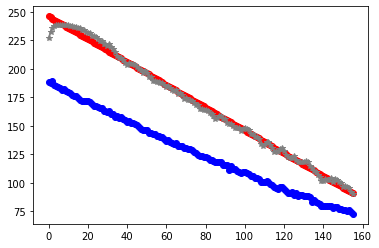

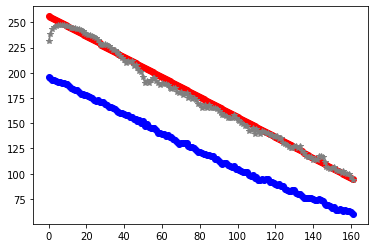

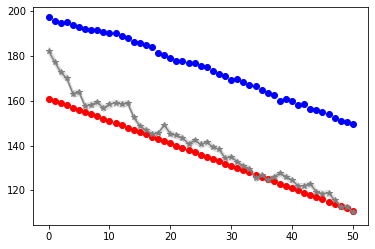

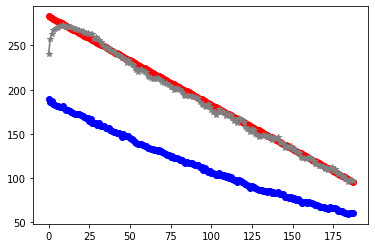

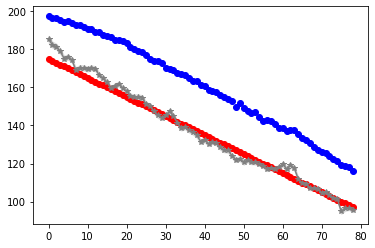

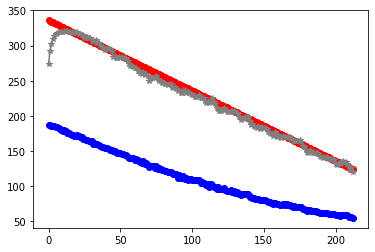

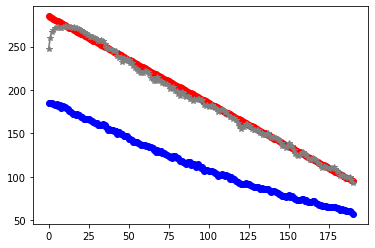

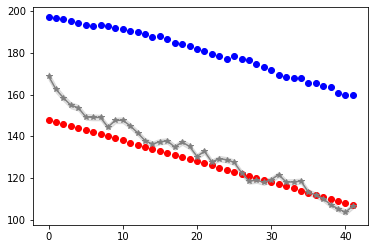

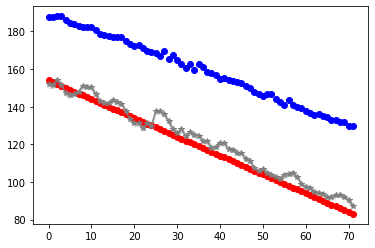

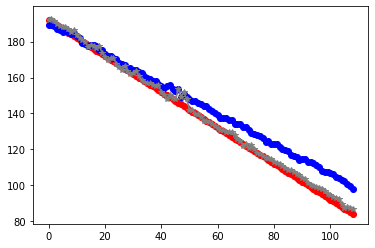

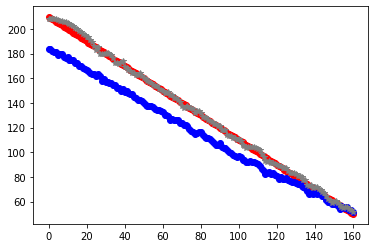

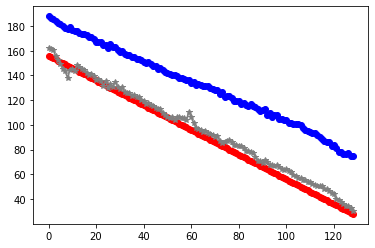

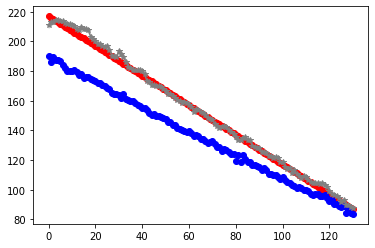

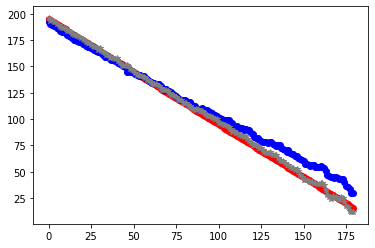

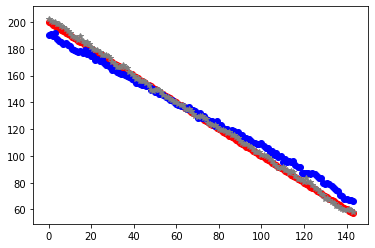

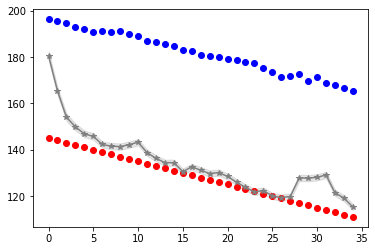

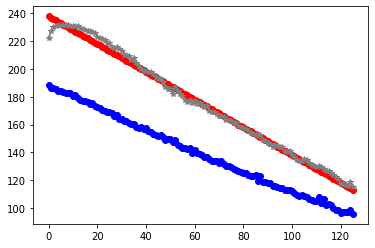

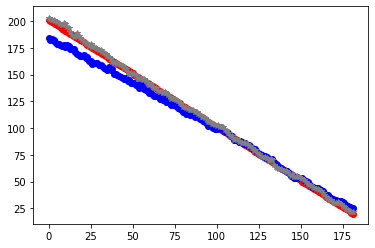

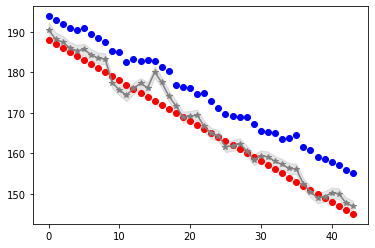

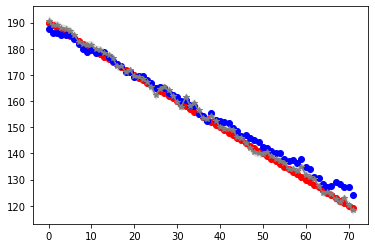

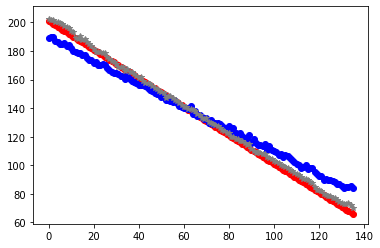

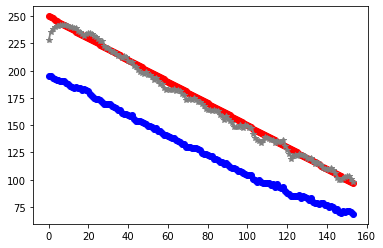

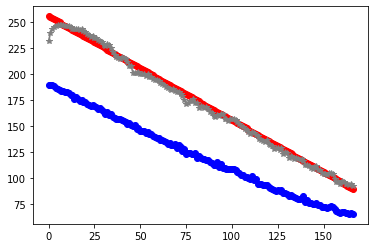

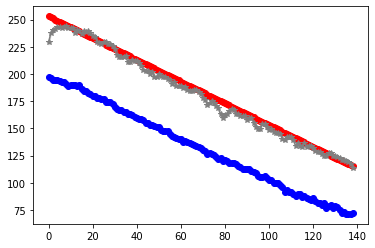

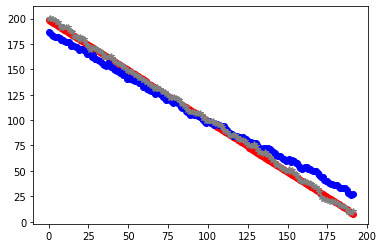

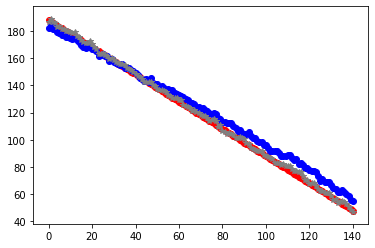

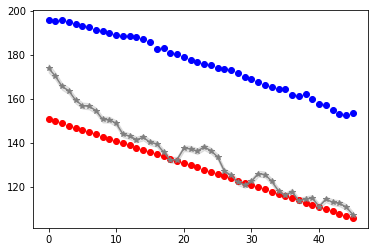

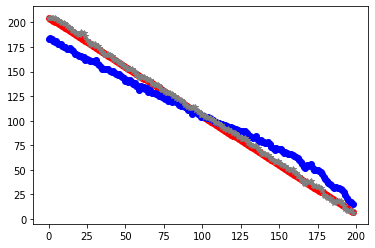

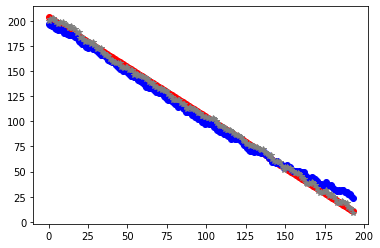

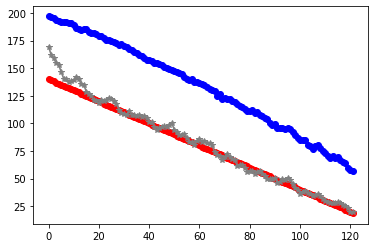

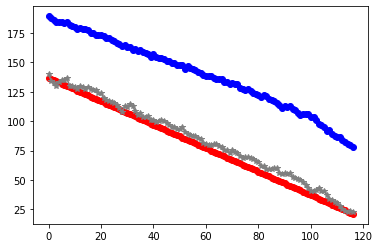

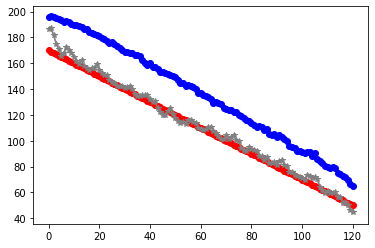

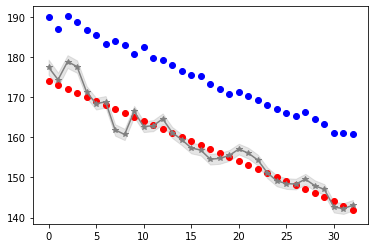

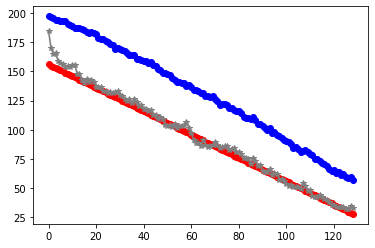

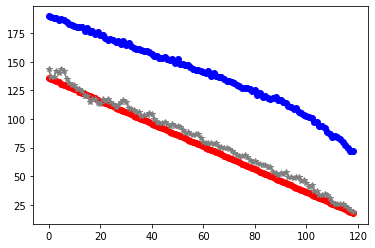

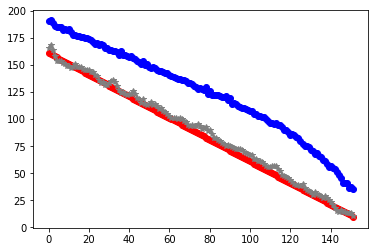

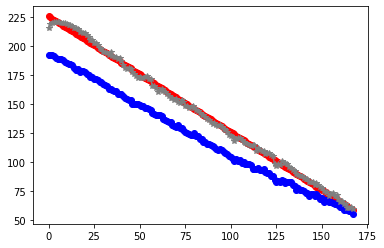

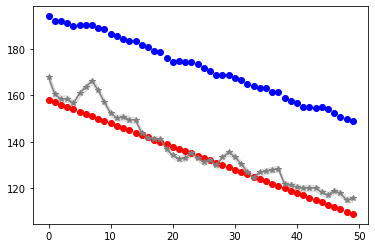

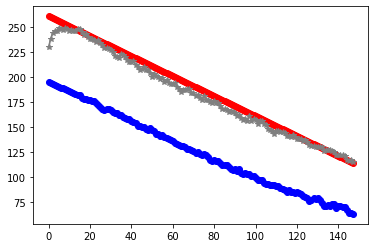

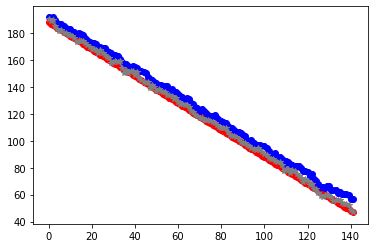

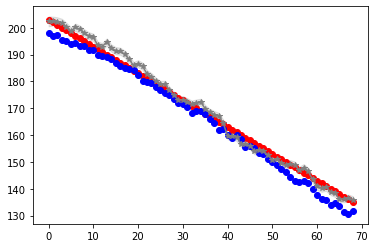

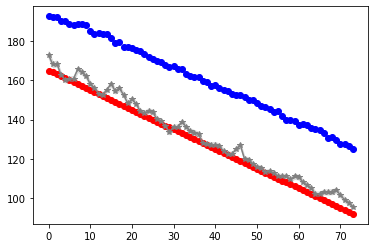

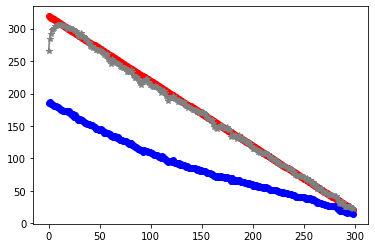

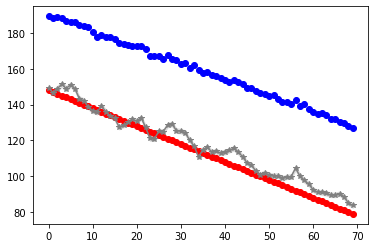

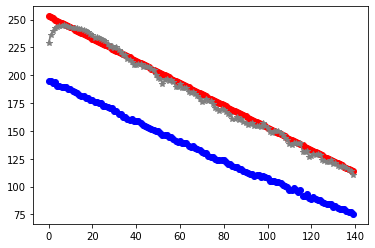

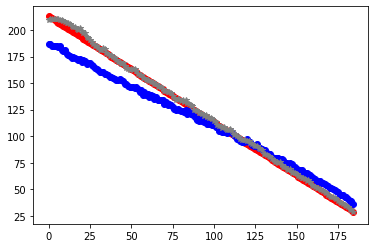

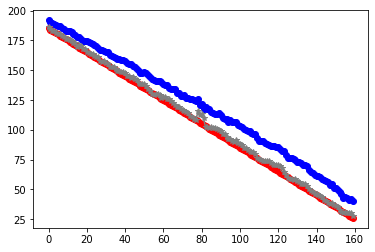

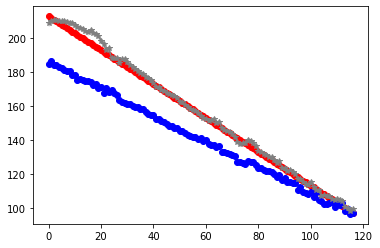

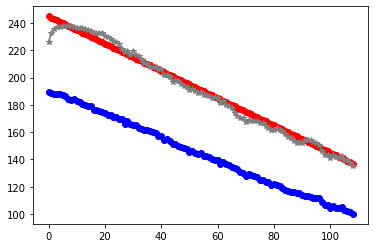

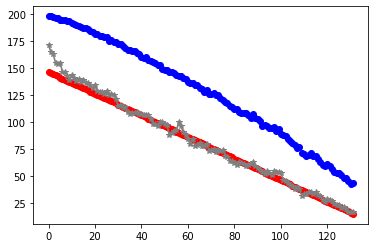

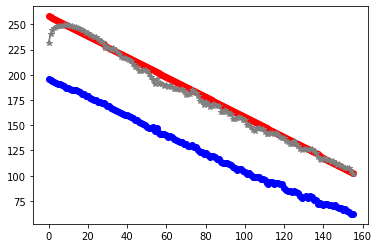

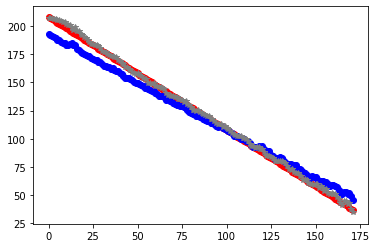

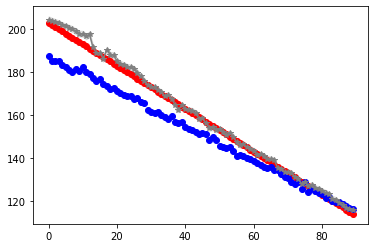

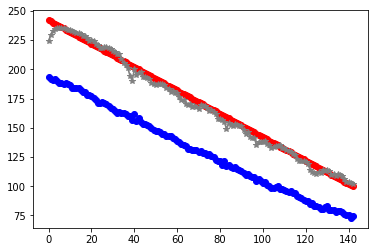

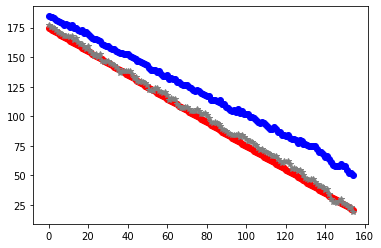

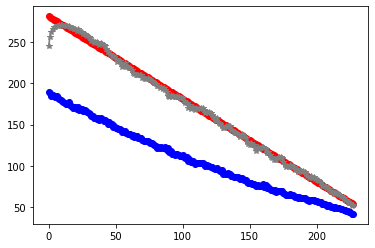

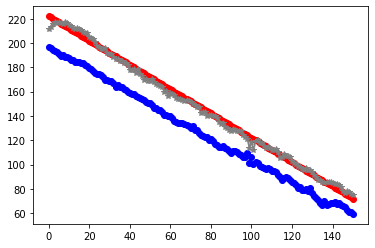

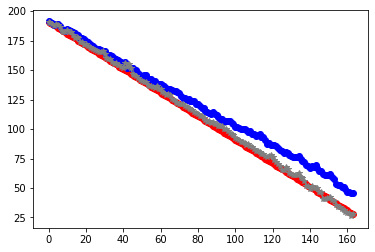

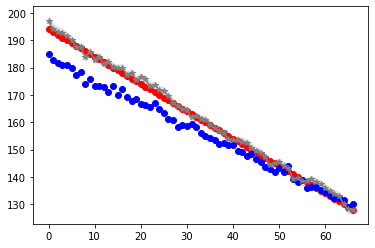

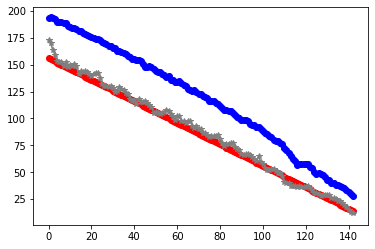

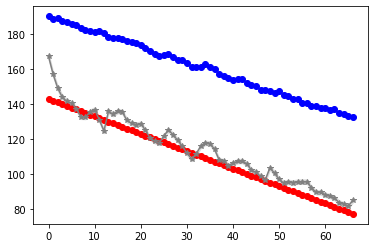

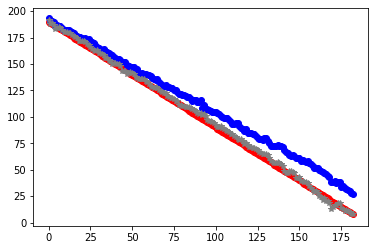

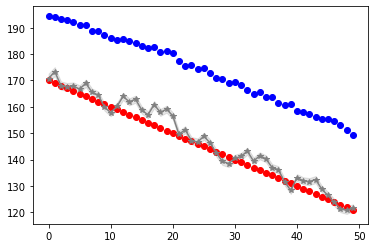

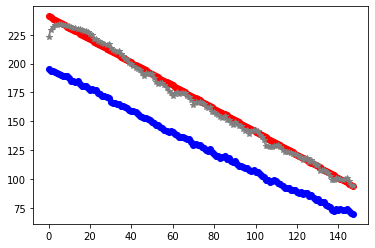

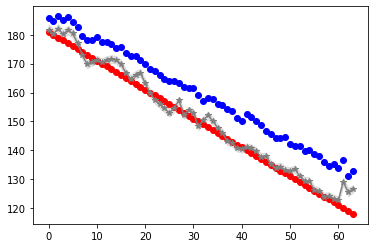

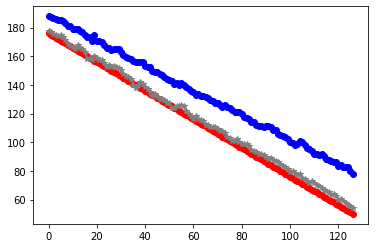

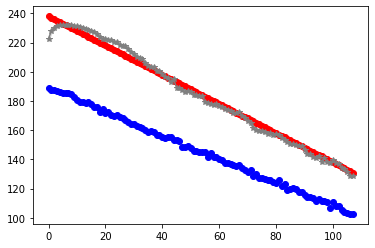

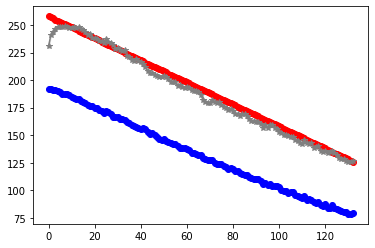

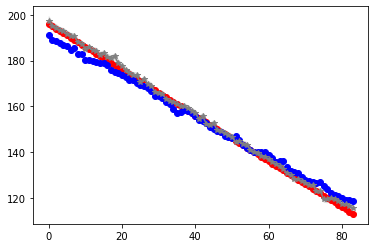

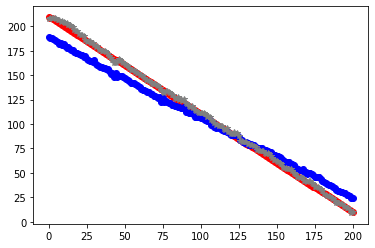

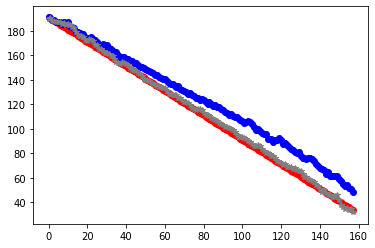

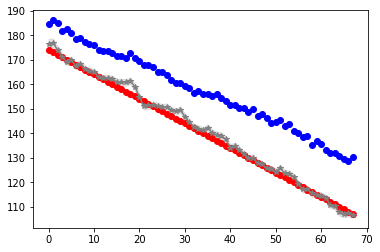

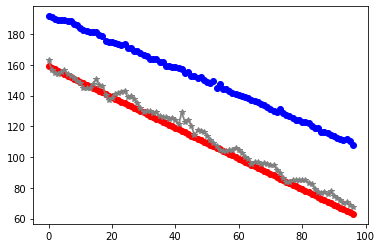

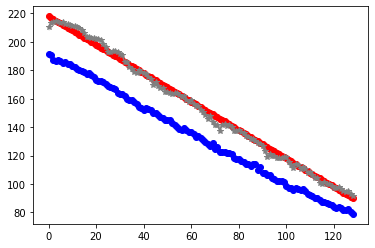

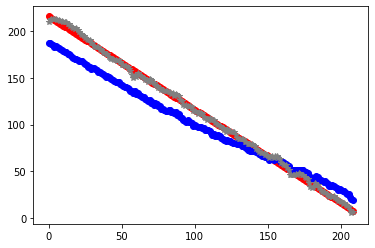

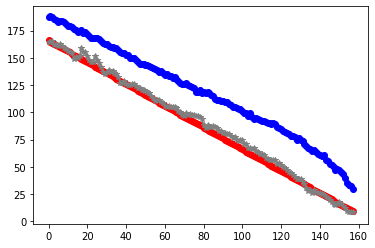

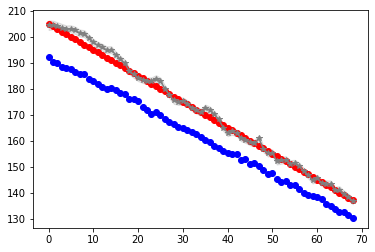

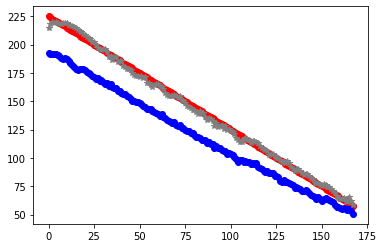

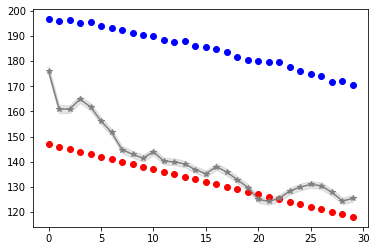

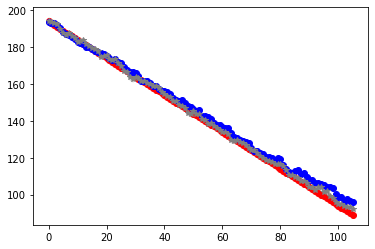

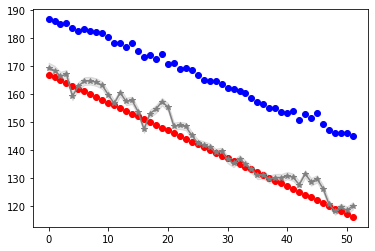

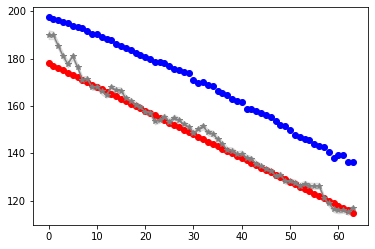

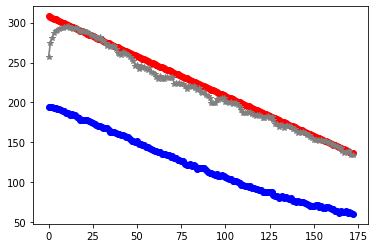

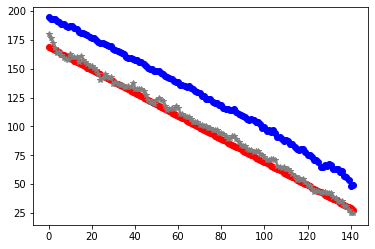

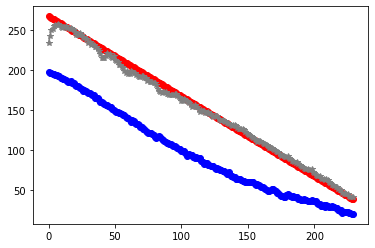

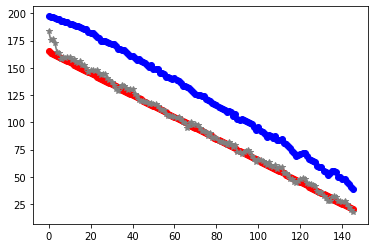

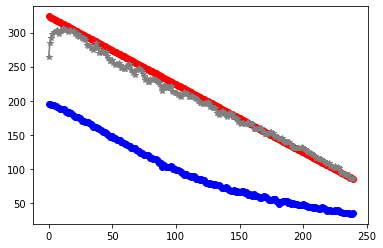

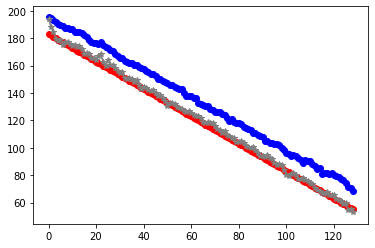

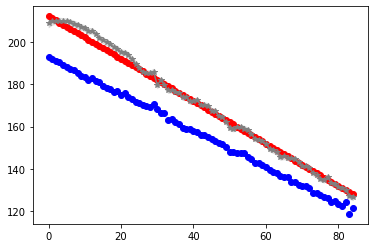

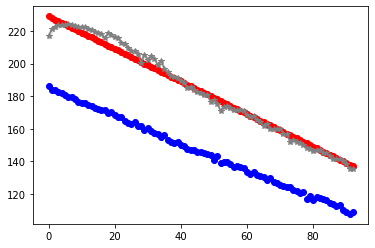

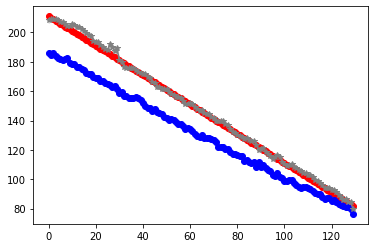

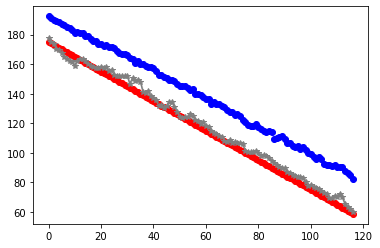

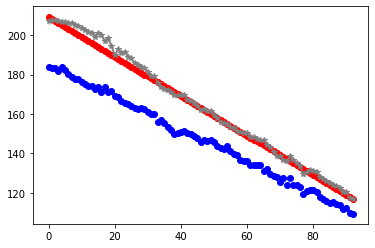

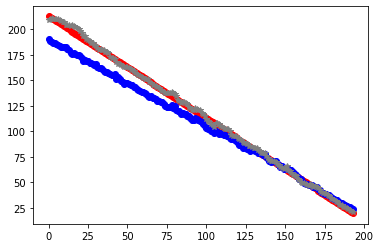

In [48]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import math 
def my_evaluate(
    model, dataloader: torch.utils.data.DataLoader, loss_fn, n_adapt, inner_lr, split,
    only_last=True, progress=True):
    rmse, rmse_mean, loss = 0., 0., 0.
    count = 0
    with tqdm(total=len(dataloader), disable=not progress) as t:
        for i, (X, y) in enumerate(dataloader):
            X = X.squeeze(0)
            y = y.view(-1)
            sample_points = [len(y) - 2] if only_last else range(len(y) - 1)
            preds = []
            true_vals = []
            pred_vars = []
            means = []
            for j in sample_points:
                # define train data and test data for last prediction
                train_X, train_y = X[:(j+1), :], y[:(j+1)]
                test_X, test_y = X[(j+1):(j+2), :], y[(j+1):(j+2)]
                # model prediction
                pred, pred_var, loss_step = model(train_X, train_y, test_X, loss_fn,
                                                inner_lr, n_adapt)
                # model mean
                mean_preds = model.gp_model.mean_function(test_X)
                mean_preds = torch.transpose(mean_preds, -1, -2)
                means.append(mean_preds.item())
                preds.append(pred.item())
                pred_vars.append(pred_var.item())
                true_vals.append(test_y)
                rmse += (pred.item() - test_y.item())**2
                rmse_mean += (mean_preds.item() - test_y.item())**2
                loss += loss_step.item()
                count += 1
            t.set_postfix(current_loss_and_rmse_and_rmseMean='{:05.3f} and {:05.3f} and {:05.3f}'.format(
                loss / count, math.sqrt(rmse / count) , math.sqrt(rmse_mean / count)))
            t.update()
            plt.figure()
            plt.plot(true_vals, 'or')
            plt.plot(means, 'ob')
            plt.plot(preds, '-*', color='gray')
            plt.fill_between(range(len(preds)), np.array(preds) - np.array(pred_vars), np.array(preds) + np.array(pred_vars),
                 color='gray', alpha=0.2)


    rmse /= count
    loss /= count
    rmse = math.sqrt(rmse)
    return rmse, loss

my_evaluate(model, torch_dataset["test"], loss_fn, n_adapt, inner_lr, "test", only_last=False)

 20%|██        | 20/100 [00:02<00:06, 11.87it/s, current_loss_and_rmse_and_rmseMean=950.663 and 2.535 and 35.055] C:\Users\Alireza\AppData\Local\Temp\ipykernel_13132\4139485729.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
100%|██████████| 100/100 [00:09<00:00, 10.80it/s, current_loss_and_rmse_and_rmseMean=798.623 and 2.678 and 29.822]


(2.678046673596308, 798.6230850982666)

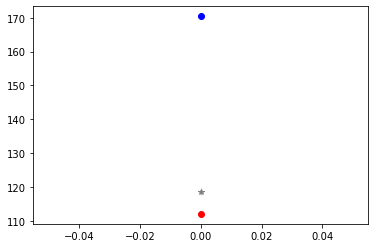

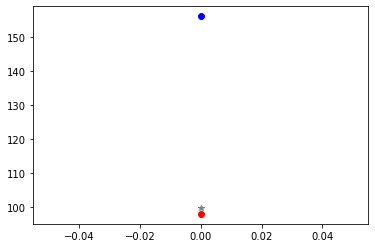

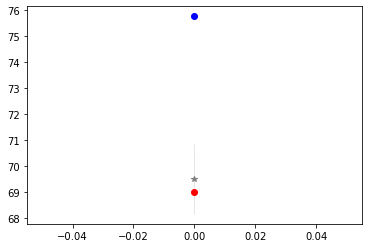

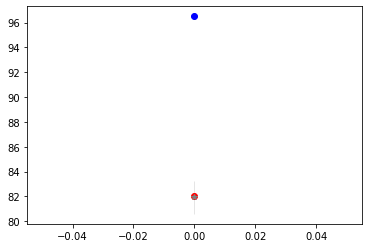

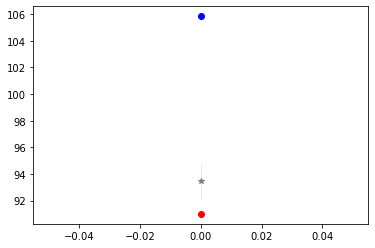

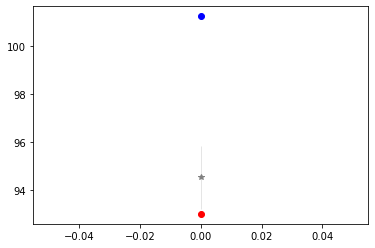

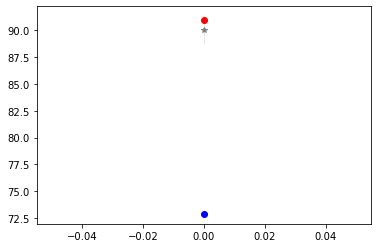

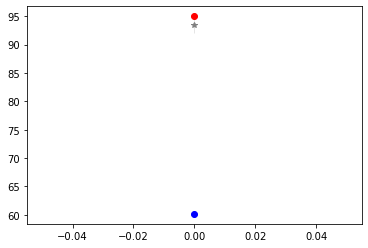

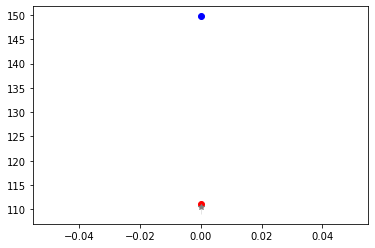

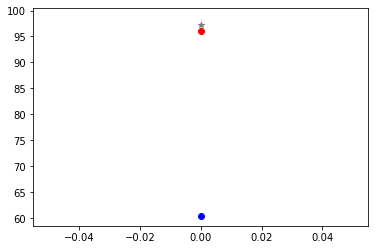

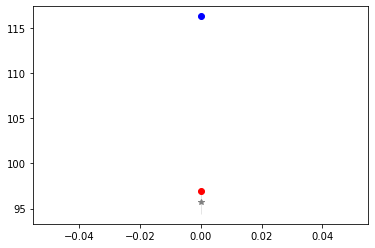

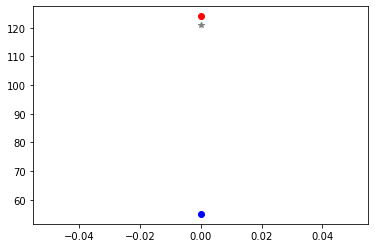

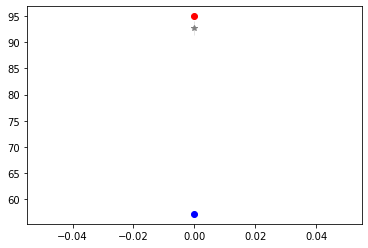

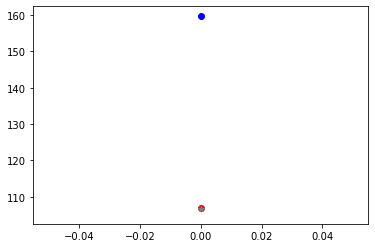

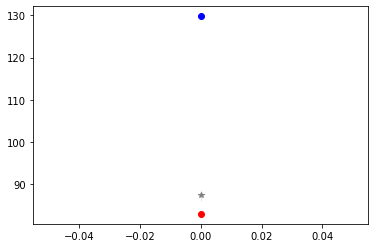

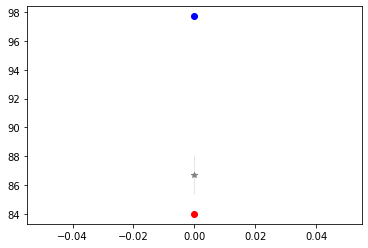

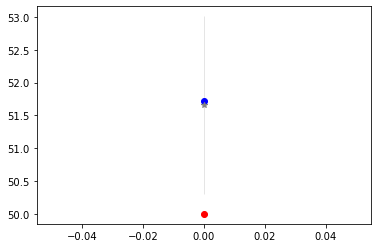

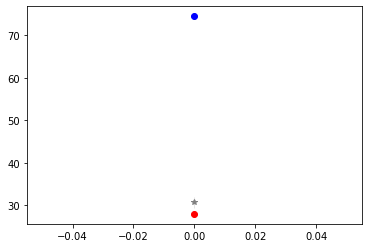

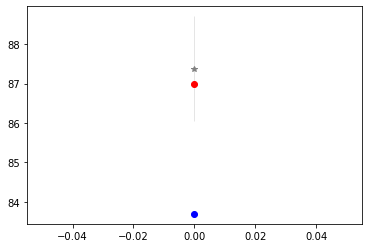

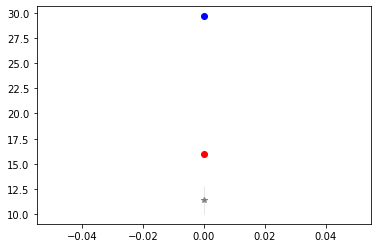

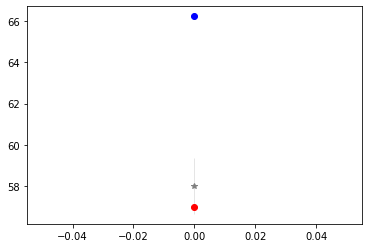

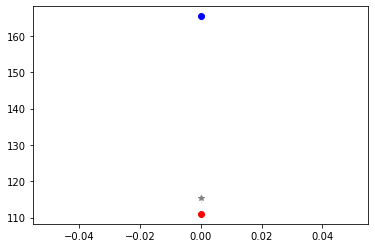

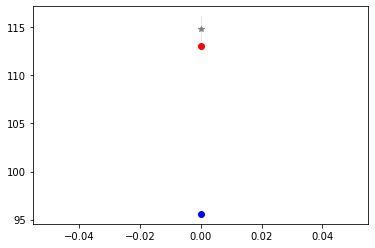

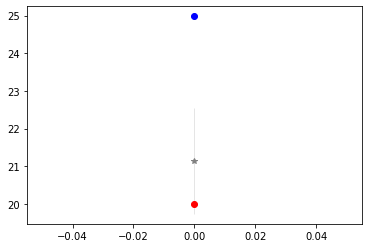

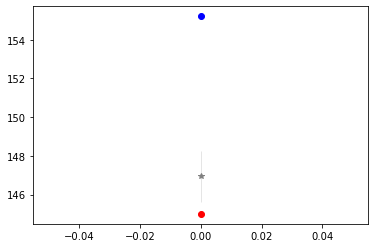

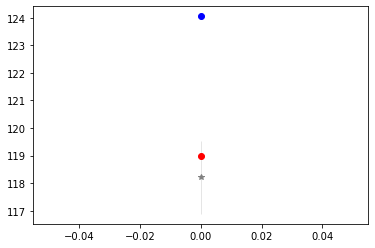

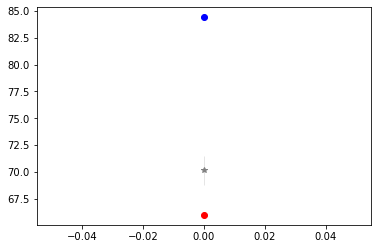

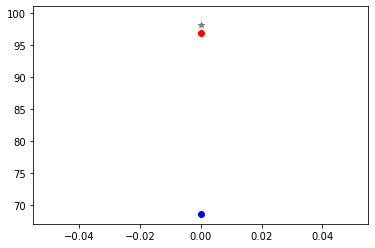

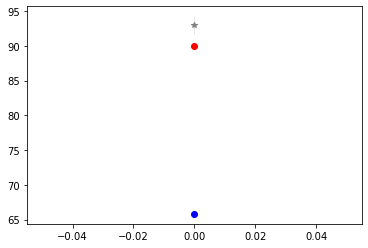

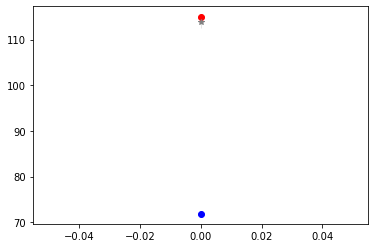

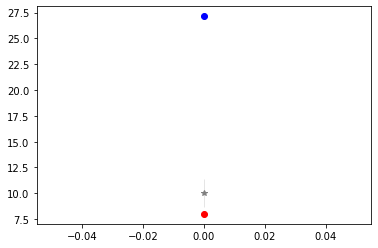

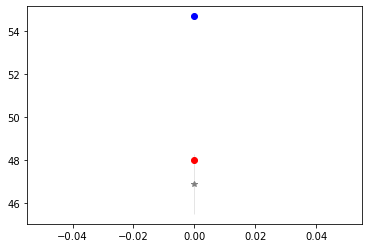

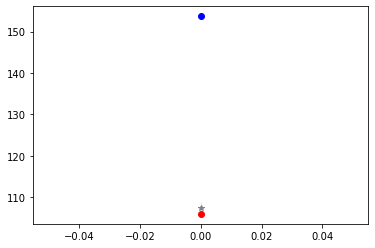

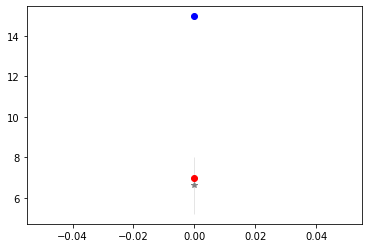

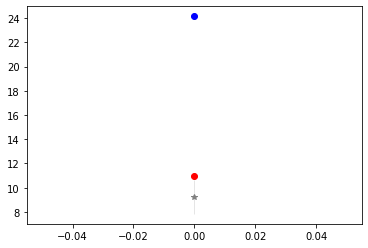

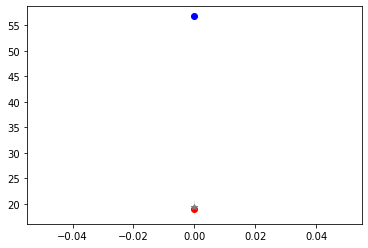

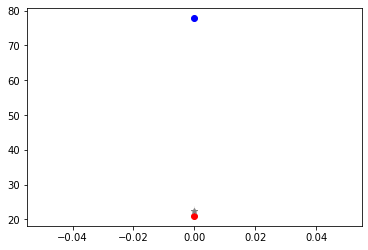

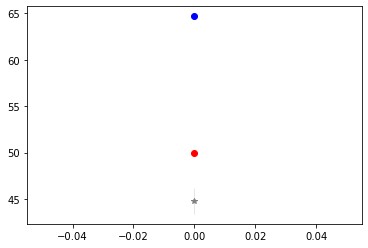

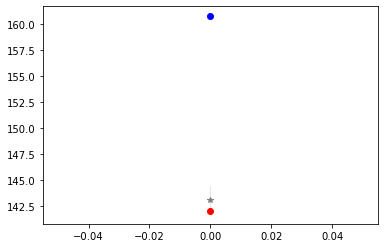

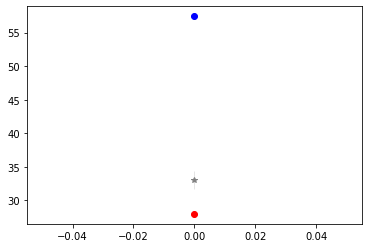

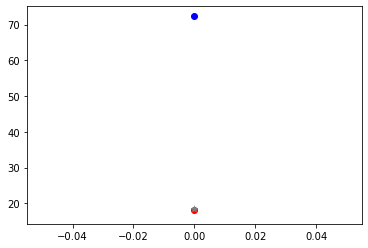

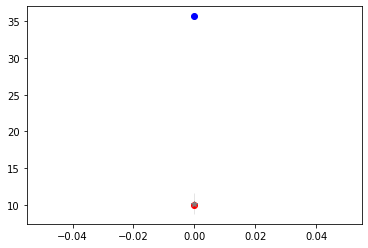

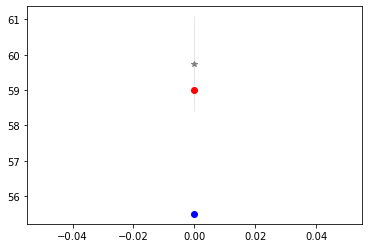

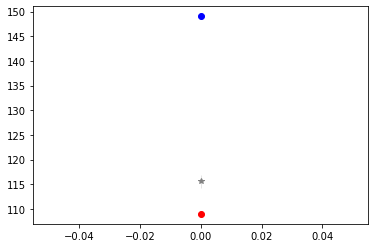

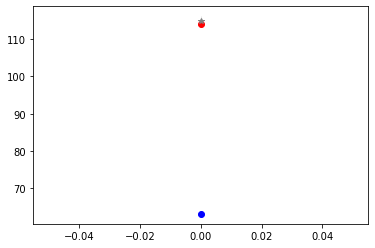

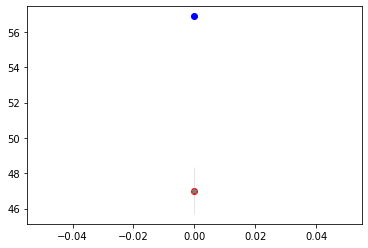

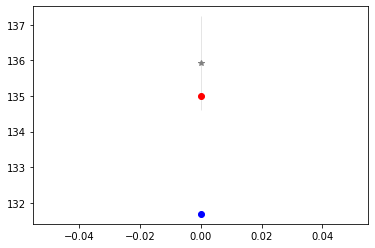

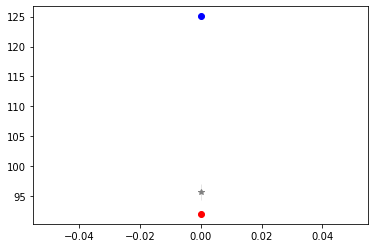

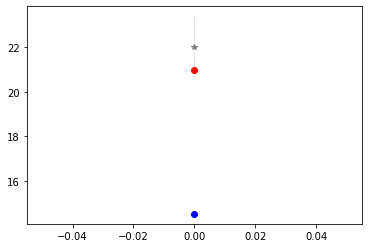

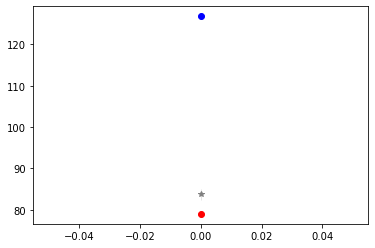

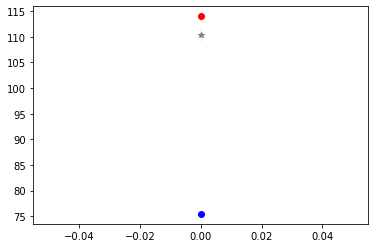

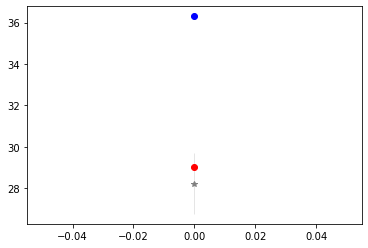

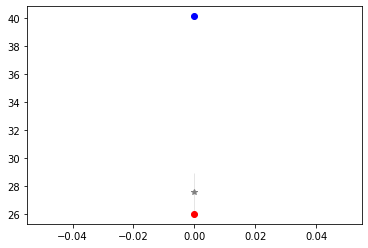

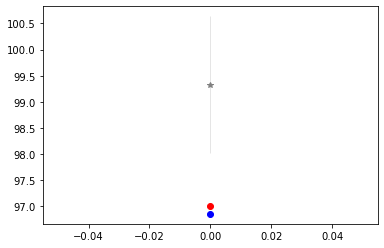

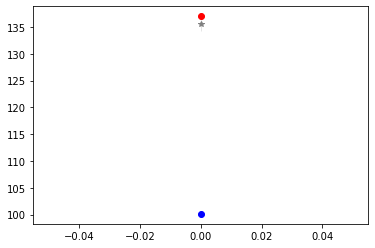

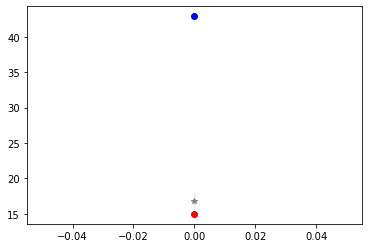

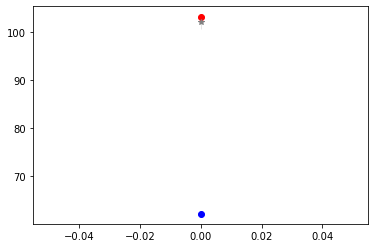

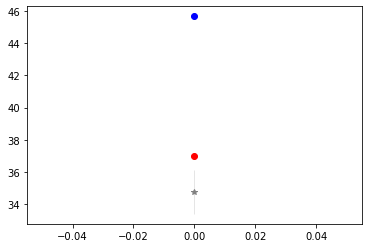

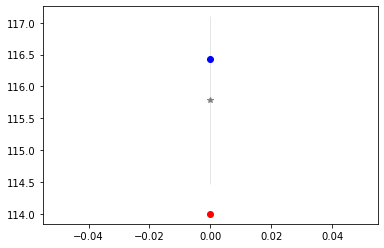

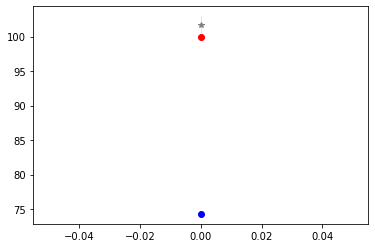

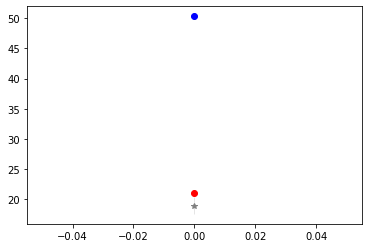

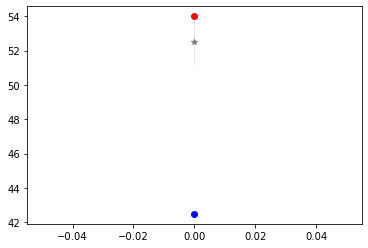

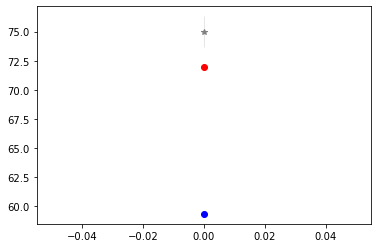

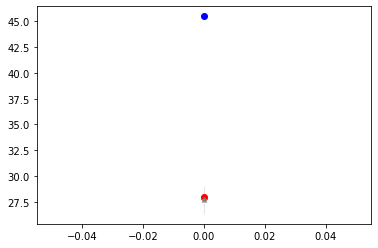

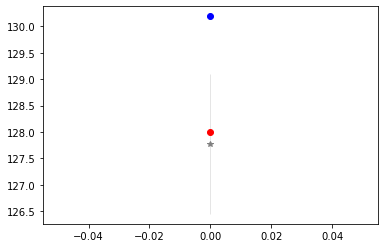

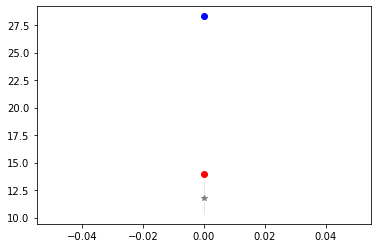

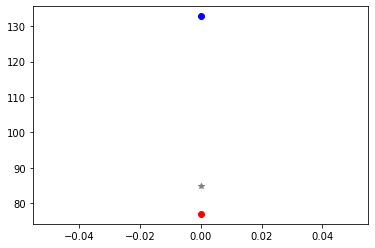

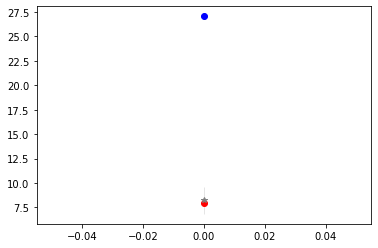

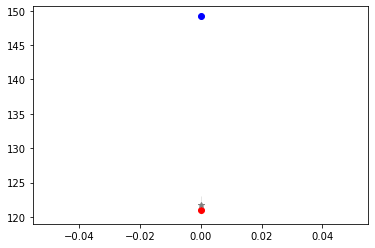

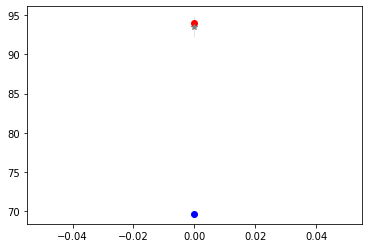

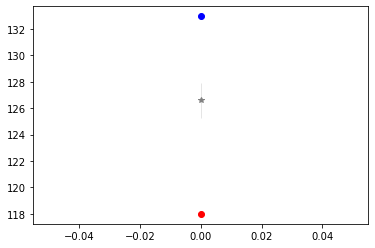

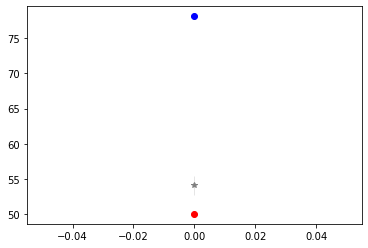

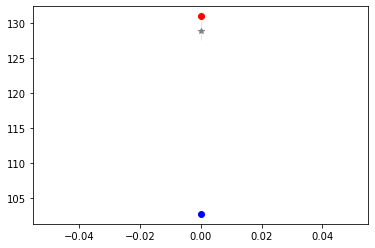

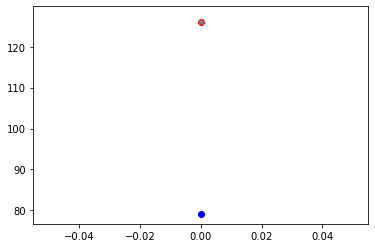

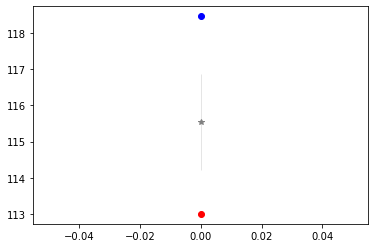

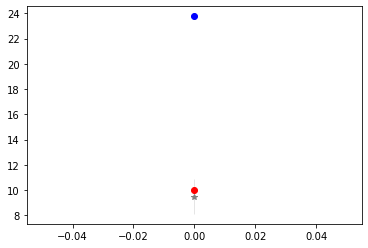

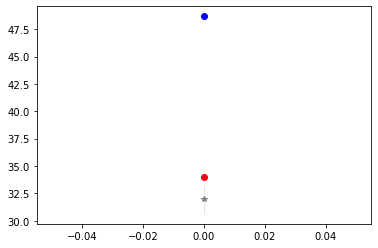

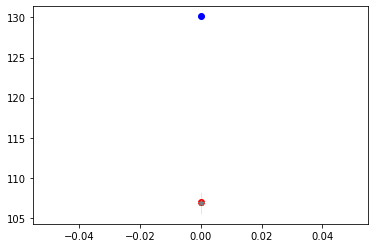

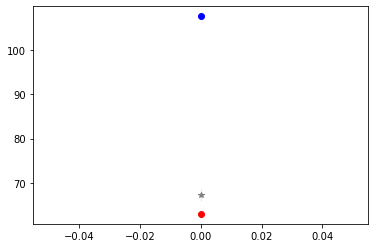

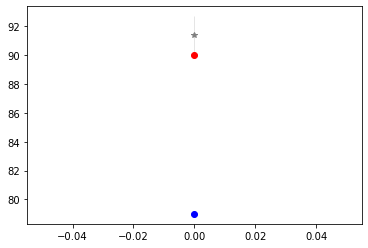

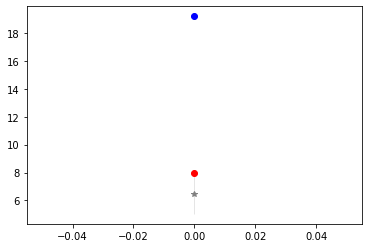

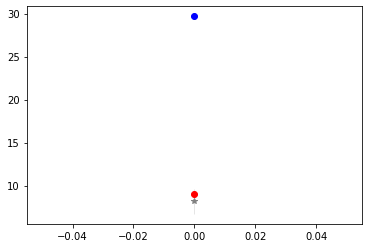

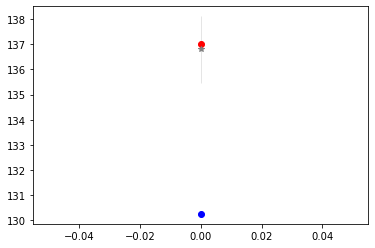

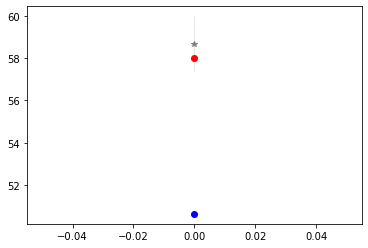

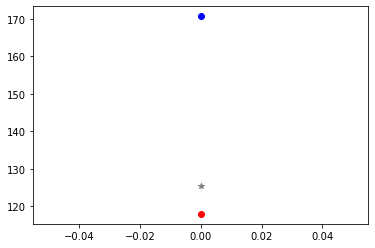

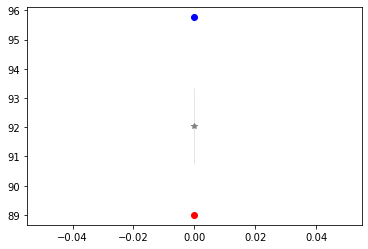

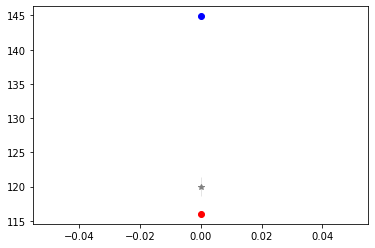

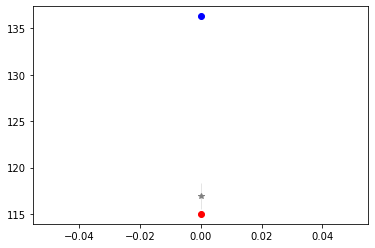

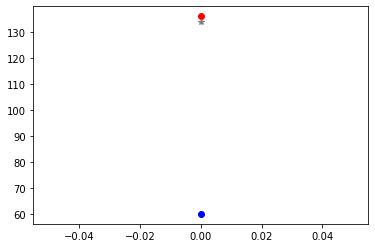

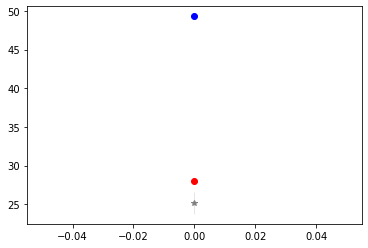

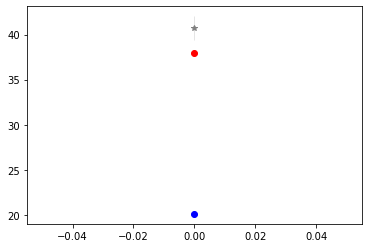

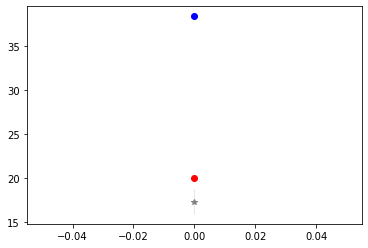

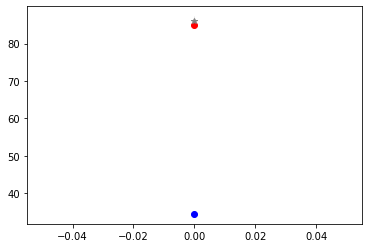

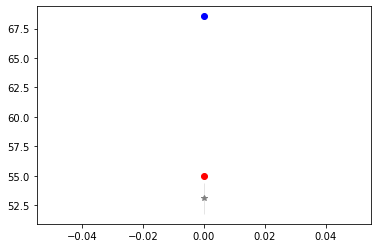

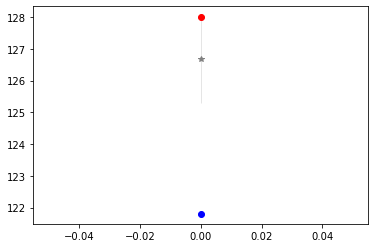

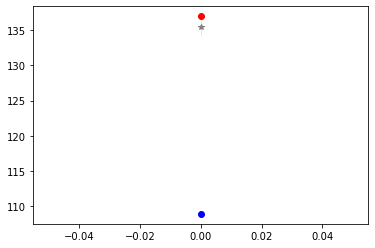

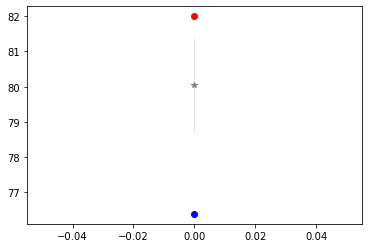

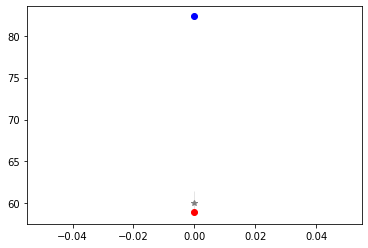

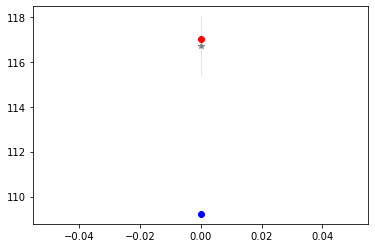

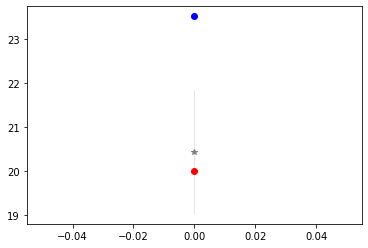

In [49]:
my_evaluate(model, torch_dataset["test"], loss_fn, n_adapt, inner_lr, "test", only_last=True)

In [5]:
state = torch.load(os.path.join(log_dir, model_name))

loaded_model = train.create_model(**state)["model"]
train.evaluate(loaded_model, torch_dataset["test"], loss_fn, n_adapt, inner_lr, "test", only_last=True)

100%|██████████| 100/100 [00:05<00:00, 18.59it/s, current_loss_and_rmse=278.422 and 4.452]


TEST_score : 4.452
TEST_loss : 278.422


(4.452241828327492, 278.4218025970459)

In [ ]:
pre.apply_scaling_fn(dataset["scaler_factory"]().fit_transform, dataset["train"]).std()